**LSTM (Long Short-Term Memory)** is an **RNN improvement** that handles long-term dependencies.

Standard RNNs suffer from the vanishing or exploding gradient problem because of recurrent connections. It also forgets the context from the earlier words when dealing with long sequences.

* It uses **gates and cell states** to control information flow.
* Widely used in **NLP**, **speech**, and **sequential** tasks.

LSTMs overcome this by having an extra recurrent state called a cell state,
 - which can be thought of as the "memory" of the LSTM
 - and they use multiple gates(input, output, forget gates) which control the flow of information into and out of the memory.

---

## What is LSTM?

**LSTM (Long Short-Term Memory)** is a special type of **Recurrent Neural Network (RNN)** architecture designed to capture **long-range dependencies** in sequential data. Unlike standard RNNs, which struggle with vanishing or exploding gradients, LSTMs can **retain information over long time steps** due to their internal gating mechanisms.

---

## Why Use LSTM?

Traditional RNNs forget older information quickly. LSTMs solve this by introducing **memory cells** and **gates** that **learn what to keep, forget, or update** — making them very effective for:

* Language modeling
* Text classification
* Time-series forecasting
* Speech recognition
* Machine translation

---

## LSTM Cell Structure

LSTM takes input of current time step, previous hidden state and cell state

An LSTM unit consists of:

1. **Cell State** `Cₜ`: Long-term memory, flowing through time with linear interactions.
2. **Hidden State** `hₜ`: Short-term output memory.
3. **Gates**:

   * **Forget Gate** `fₜ`: Decides what to forget.
   * **Input Gate** `iₜ`: Decides what new info to store.
   * **Output Gate** `oₜ`: Decides what to output.

Each gate is controlled using a **sigmoid activation**, outputting values in `[0, 1]` (i.e., how much to let through).

Cell state is managed with **tanh activation** because it was popular at the time LSTM was introduced

---

### Key Equations

For input `xₜ`, previous hidden state `hₜ₋₁`, and cell state `Cₜ₋₁`:


$i_t = \sigma{(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi})}$  # Input gate

$f_t = \sigma{(W_{if} x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})}$  # Forget gate

$g_t = tanh(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})$  # Cell state

$c_t = f_t * c_{t-1} + i_t * g_t$  # Final cell state

$o_t = \sigma{(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})}$  # Output gate

$h_t = o_t * tanh(c_t)$ # Final hidden state


---



Long Short-Term Memory (LSTM) networks address the limitations of traditional RNNs by maintaining long-term dependencies through a unique gating mechanism. Here’s a step-by-step explanation of the LSTM workflow:

1. Input Processing

Each LSTM cell receives input data (x_t) at a specific time step along with the previous hidden state (h_t-1) and cell state (C_t-1). This combination allows the network to consider both current and historical information.

2. Forget Gate

The forget gate determines which parts of the previous cell state (C_t-1) should be discarded. It uses a sigmoid function to produce values between 0 and 1, where 0 means “forget this information” and 1 means “retain completely.”


3. Input Gate

    The input gate updates the cell state with new information. It comprises two parts:

    - Candidate State: A tanh layer generates potential updates (g_t).
    - Update Decision: A sigmoid layer decides the importance of the candidate state.


4. Cell State Update

    The forget gate and input gate combine to update the cell state (C_t):


5. Output Gate

    The output gate decides which parts of the cell state should influence the hidden state (h_t). It applies a sigmoid function to select the relevant parts, followed by a tanh transformation to produce the final hidden state $h_T$

The initial cell state, C0, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

Thus, the model using an LSTM looks something like:

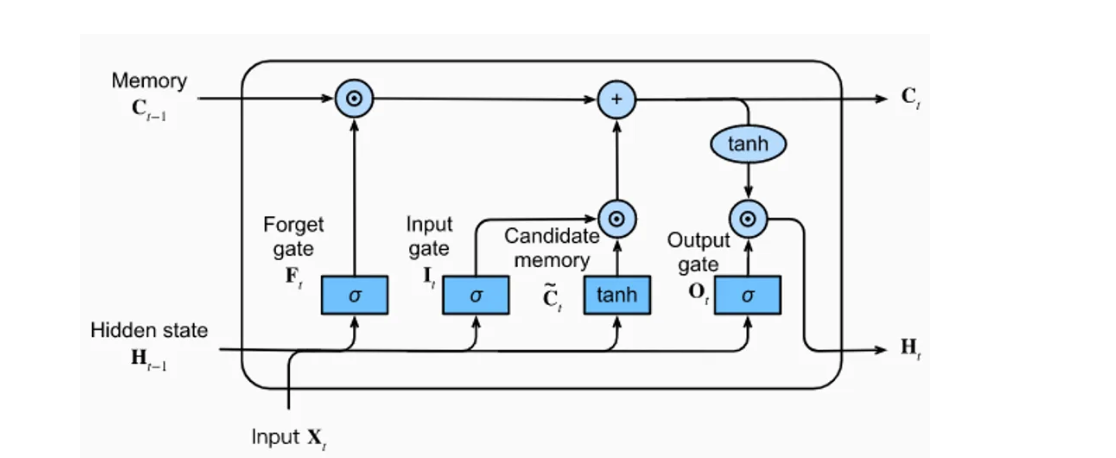

## LSTM Variants

| Variant               | Description                                                                   |
| --------------------- | ----------------------------------------------------------------------------- |
| **Vanilla LSTM**      | The standard version as described above.                                      |
| **Peephole LSTM**     | Gates also see the **cell state** directly.                                   |
| **Coupled Gate LSTM** | Combines input and forget gate to reduce parameters.                          |
| **BiLSTM**            | Processes sequences **in both directions**, often used in encoders.           |
| **Stacked LSTM**      | Multiple LSTM layers stacked on top of each other for deep sequence modeling. |

---

Here, we implement a `bidirectional multilayer LSTM`

Note: time steps are nothing but words in a single sequence. We will batch of such sequences. A sequence is a set of words.




In implementation, to use an LSTM instead of the standard RNN, we use nn.LSTM instead of nn.RNN. Also, note that the LSTM returns the output and a tuple of the final hidden state and the final cell state, whereas the standard RNN only returned the output and final hidden state.



In [ ]:
!pip install torchtext torchdata --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install "numpy<2"

In [ ]:
!pip install portalocker>=2.0.0

In [ ]:
import torch
torch.__version__

'2.2.0+cu118'

In [ ]:
import numpy
numpy.__version__

'1.26.4'

In [ ]:
import torchtext
torchtext.__version__

'0.17.0+cpu'

In [ ]:
!pip list | grep torch

torch                                 2.6.0+cu124
torchaudio                            2.6.0+cu124
torchdata                             0.11.0
torchsummary                          1.5.1
torchtext                             0.18.0
torchvision                           0.21.0+cu124


In [ ]:
import torch, torchtext
from torch import nn as nn

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader

from torchtext.vocab import build_vocab_from_iterator, FastText

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import matplotlib.pyplot as plt

import time

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Prepare Dataset
train, test = AG_NEWS()

train_length = len(list(iter(train)))
train, val, rem = train.random_split(total_length=train_length, weights={"train": 0.2, "val": 0.1, "rem": 0.7}, seed=SEED)

train_size_length = len(list(iter(train)))
val_size_length = len(list(iter(val)))
test_size_length = len(list(iter(test)))

print("Train {}, Val: {}, Test: {}".format(train_size_length, val_size_length, test_size_length))

In [ ]:
# Build the vocab and dictionaries and numericalize

tokenizer = get_tokenizer(tokenizer="spacy", language="en_core_web_sm")

def yield_tokens(train_data):
    for _label, _text in train:
        tokens =  tokenizer(_text)
        yield tokens

word2idx = build_vocab_from_iterator(yield_tokens(train), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
word2idx.set_default_index(word2idx["<unk>"])
idx2word = word2idx.get_itos()
vocab_size = len(word2idx)

pad_idx = word2idx["<pad>"]  # making sure our embedding layer ignores pad

print("Total Vocab: {}".format(vocab_size))

In [ ]:
# Model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)  # put padding_idx so asking the embedding layer to ignore padding
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # bidirection, so hidden dimensions in 2 directions

    def forward(self, input, text_lengths):
        embeds = self.embedding(input)                                                         # (bs, seq_len) -> (bs, seq_len, embed_dim)
        packed_embeds = pack_padded_sequence(embeds, lengths=text_lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        packed_output, (packed_hn, packed_cell_state) = self.lstm(packed_embeds)                # hn=(num layers * num directions, bs, hidden_dim), c=(num layers * num directions, bs, hidden_dim)
        output, lengths = pad_packed_sequence(packed_output, batch_first=True)                  # (bs, seq_len, hidden_dim * num_directions), (bs,)  # unpack in case we need to use it #   output over padding tokens are zero tensors
        logits = self.fc(packed_hn.squeeze(dim=0))                                              # (1, bs, hidden_dim) -> (bs, hidden_dim) -> (bs, output_dim)

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers to get the final hidden state
        hn = torch.cat((packed_hn[-2, :, :], packed_hn[-1, :, :]), dim=1)                       # (bs, hidden_dim * num_directions)
        logits = self.fc(hn)                                                                    # (bs, output_dim)
        return logits


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.orthogonal_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [ ]:
def count_params(m):
    counts = [param.numel() for name, param in m.named_parameters() if param.requires_grad]
    for item in counts:
        print(f"{item:>6}")
    print(f"---------\n{sum(counts):>6}")

def accuracy(pred_logits, y_true):
    y_pred = torch.max(pred_logits.data, dim=1)[1]
    batch_accuracy = (y_pred == y_true).sum()
    accuracy = batch_accuracy / len(y_true)
    return accuracy

def elapsed_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
text_pipeline = lambda t: word2idx(tokenizer(t))
label_pipeline = lambda l: int(l)- 1   # for pytorch training, labels index to start from 0

def collate_batch(batch):
    labels, texts, lengths = [], [], []
    for (_label, _text) in batch:
        labels.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        texts.append(processed_text)
        lengths.append(processed_text.size(0))
    return torch.tensor(labels, dtype=torch.int64), pad_sequence(texts, batch_first=True, padding_value=pad_idx), torch.tensor(lengths, dtype=torch.int64)


In [ ]:
def train_step(model, train_dataloader, optimizer, criterion, train_dataloader_length):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for idx, (label, text, lengths) in enumerate(train_dataloader):
        label = label.to(device)
        text = text.to(device)
        lengths = lengths.to(device)
        optimizer.zero_grad()
        logits = model(text, lengths)
        loss = criterion(logits.squeeze(dim=1), label)
        acc = accuracy(logits, label)
        train_loss += loss.item()
        train_acc += acc.item()
        loss.backward()
        optimizer.step()
    train_epoch_loss = train_loss / train_dataloader_length
    train_epoch_acc = train_acc / train_dataloader_length
    return train_epoch_loss, train_epoch_acc

In [ ]:
def val_step(model, val_dataloader, criterion, val_dataloader_length):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for idx, (label, text, lengths) in enumerate(val_dataloader):
            label = label.to(device)
            text = text.to(device)
            lengths = lengths.to(device)
            logits = model(text, lengths)
            loss = criterion(logits.squeeze(dim=1), label)
            acc = accuracy(logits, label)
            val_loss += loss.item()
            val_acc += acc.item()
        val_epoch_loss = val_loss / val_dataloader_length
        val_epoch_acc = val_acc / val_dataloader_length
    return val_epoch_loss, val_epoch_acc

In [ ]:
# Training
batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val, batch_size=batch_size, collate_fn=collate_batch)
test_dataloader = DataLoader(test, batch_size=batch_size, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_dataloader)))
val_loader_length = len(list(iter(val_dataloader)))
test_loader_length = len(list(iter(test_dataloader)))

input_dim = len(word2idx)
embed_dim = 300
hidden_dim = 256
output_dim = 4
num_layers = 2
bidirectional = True
dropout = 0.5

model = BiLSTM(input_dim, embed_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout)
model.apply(init_weights)
model.to(device)

count_params(model)

fast_text = FastText(language="simple")
fast_vectors = fast_text.get_vecs_by_tokens(tokens=word2idx.get_itos()).to(device)
print(f"Fast Text Embeddings shape: {fast_vectors.shape}")  # vocab, emb_dim=300
model.embedding.weight.data = fast_vectors                  # applied the fast text embedding as the initial weights

epochs = 5
best_loss = float("inf")
save_path = f"/content/{model.__class__.__name__}.pt"

optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_step(model, train_dataloader, optimizer, criterion, train_loader_length)
    val_loss, val_acc = val_step(model, val_dataloader, criterion, val_loader_length)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)
    end_time = time.time()
    elapsed_mins, elapsed_secs = elapsed_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

In [ ]:
# Plotting
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label="Train Loss")
ax.plot(val_losses, label="Val Loss")
plt.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label="Train Accurcay")
ax.plot(val_accs, label="Val Accuracy")
plt.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.show()

In [ ]:
# Test
model.load_state_dict(torch.load(save_path))
test_loss, test_acc = val_step(model, test_dataloader, criterion, test_loader_length)
print(f"\n Test Loss: {test_loss:3.5f} | Test Loss: {test_acc:3.5f}")

In [ ]:
# Predict
def predict(text):
    with torch.no_grad():
        input = torch.tensor(text_pipeline(text)).to(device)
        input = input.reshape(1, -1)
        length = torch.tensor([input.size(1)], dtype=torch.int64)
        logits = model(input, length)
        prediction = torch.max(logits.data, dim=1)[1]
        return prediction

predict("Google is now falling nonstop.  The price is really bad now.")

In general, LSTM provides a very strong baseline for all kind of sequential data. Anyhow, LSTM still suffer when the sequence is very long (500+). In that case, we may want to use convolution instead. (PS:later we ll use transformers)